# Loading libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Embedding, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# Generating and splitting data for models

In [ ]:
import pandas as pd
merged_data_short = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/merged_data_short.csv")



## Removing 50 sampled satation

In [ ]:
# Define aggregation dictionary for variables other than 'start_count'
agg_funcs = {col: 'first' for col in merged_data_short.columns if col not in ['station_id_encoded', 'hour', 'date', 'start_count']}
agg_funcs['start_count'] = 'sum'

# Grouping the data
merged_data_short = merged_data_short.groupby(['station_id_encoded', 'hour', 'date'], as_index=False).agg(agg_funcs)

In [ ]:
random_stations = merged_data_short['station_id_encoded'].drop_duplicates().sample(n=50, random_state=42)

# Exclude these stations from the dataset
merged_data_short_sample = merged_data_short[~merged_data_short['station_id_encoded'].isin(random_stations)]


## Adding dummy time slots and weekend variables

In [ ]:
merged_data_short_sample['date'] = pd.to_datetime(merged_data_short_sample['date'])

# Define the function to create dummy variables for time of day
def time_of_day_dummy(hour):
    if 0 <= hour < 7:
        return 'early_morning'
    elif 7 <= hour < 9:
        return 'morning_rush'
    elif 9 <= hour < 12:
        return 'late_morning'
    elif 12 <= hour < 16:
        return 'lunch_time'
    elif 16 <= hour < 19:
        return 'afternoon_rush'
    elif 19 <= hour <= 23:
        return 'evening'
    else:
        return 'invalid_hour'

# Apply the function to create a new column with time of day categories
merged_data_short_sample['time_of_day'] = merged_data_short_sample['hour'].apply(time_of_day_dummy)

# Now we create dummy variables from the 'time_of_day' column
time_of_day_dummies = pd.get_dummies(merged_data_short_sample['time_of_day'], prefix='dummy')

# Join the dummy variables with the main dataframe
merged_data_short_sample = merged_data_short_sample.join(time_of_day_dummies)

# Drop the 'time_of_day' column as it's no longer needed
merged_data_short_sample.drop('time_of_day', axis=1, inplace=True)




In [ ]:
# Define a function to identify weekends
def is_weekend(date):
    if date.weekday() >= 5:
        return 1
    else:
        return 0

# Apply the function to create the weekend dummy variable
merged_data_short_sample['weekend_dummy'] = merged_data_short_sample['date'].apply(is_weekend)

## Splitting and standardizing

In [ ]:
# Sort by 'date'
merged_data_short_sorted = merged_data_short_sample.sort_values(by=['date', 'station_id_encoded', 'hour'])

# Drop columns not used for features or target
merged_data_short_sorted.drop(columns=["station_name", "short_name"], inplace=True)

# Reset index after sorting
merged_data_short_sorted.reset_index(drop=True, inplace=True)

# Split sorted data into features (X) and target (y)
X_sorted = merged_data_short_sorted.drop('start_count', axis=1)
y_sorted = merged_data_short_sorted['start_count']

# Split data on dates
train_end_index = X_sorted[X_sorted['date'] == '2022-11-30'].index[-1]
val_end_index = X_sorted[X_sorted['date'] == '2023-03-10'].index[-1]

# Split the data manually
X_train = X_sorted.iloc[:train_end_index]
y_train = y_sorted.iloc[:train_end_index]
X_val = X_sorted.iloc[train_end_index:val_end_index]
y_val = y_sorted.iloc[train_end_index:val_end_index]
X_test = X_sorted.iloc[val_end_index:]
y_test = y_sorted.iloc[val_end_index:]

In [ ]:
X_train.drop(columns=["date"], inplace=True)
X_val.drop(columns=["date"], inplace=True)
X_test.drop(columns=["date"], inplace=True)


In [ ]:
# Feature columns to be standardized
feature_columns = ["hour", "longitude", "latitude", "temperature_2m (°C)",
                   "relativehumidity_2m (%)", "precipitation (mm)", "snowfall (cm)",
                   "cloudcover (%)", "direct_radiation (W/m²)", "windspeed_10m (km/h)",
                   "bike_lane_length_km", "restaurants_count", "rail_stations_count",
                   "universities_count", "bus_stations_count", "capacity", "businesses_count", "parks_count"]

# Create the Normalization layer and adapt it to the training data
standardizer = tf.keras.layers.Normalization(axis=-1)
standardizer.adapt(X_train[feature_columns])

# Apply the standardizer to the training data
X_train[feature_columns] = standardizer(X_train[feature_columns].values)

# Apply the standardizer to the validation data
X_val[feature_columns] = standardizer(X_val[feature_columns].values)

# Apply the standardizer to the test data
X_test[feature_columns] = standardizer(X_test[feature_columns].values)


# Adapt the standardizer to the training data target variable
target_standardizer = tf.keras.layers.Normalization(axis=-1)

target_standardizer.adapt(y_train.to_frame())

# Apply the standardizer to the training data target variable
y_train = target_standardizer(y_train.to_frame()).numpy().flatten()

# Apply the standardizer to the validation data target variable
y_val = target_standardizer(y_val.to_frame()).numpy().flatten()

# Apply the standardizer to the test data target variable
y_test = target_standardizer(y_test.to_frame()).numpy().flatten()

In [ ]:
y_train = pd.DataFrame(y_train, columns=['start_count'])
y_test = pd.DataFrame(y_test, columns=['start_count'])
y_val = pd.DataFrame(y_val, columns=['start_count'])

In [ ]:
# Number of unique stations in the dataset
num_stations = X_val['station_id_encoded'].nunique()

# Maximum value of station ID (needed to define the input dimension of the embedding layer)
max_station_id = int(X_val['station_id_encoded'].max()) + 1

# Define the embedding size
# Rule of thumb: min(50, number of categories/2)
embedding_size = min(50, num_stations // 2)
num_stations

214

# Batch generator with ID's

In [ ]:
station_ids_train = X_train['station_id_encoded']
station_ids_val = X_val['station_id_encoded']
station_ids_test = X_test['station_id_encoded']

In [ ]:
def modified_batch_generator(X, y, station_ids, time_steps=24, batch_size=256, infinite_loop=True):
    total_size = len(X)
    start_idx = 0

    while True:
        X_batch = np.zeros((batch_size, time_steps, X.shape[1]))
        station_id_batch = np.zeros((batch_size, 1))
        y_batch = np.zeros((batch_size, time_steps, 1))

        for i in range(batch_size):
            if start_idx + time_steps <= total_size:
                X_seq = X.iloc[start_idx:start_idx + time_steps]
                y_seq = y.iloc[start_idx:start_idx + time_steps]
                station_id = station_ids.iloc[start_idx + time_steps - 1]

                # Padding in case of insufficient data
                X_pad = np.zeros((time_steps, X.shape[1]))
                y_pad = np.zeros((time_steps, 1))
                X_pad[:len(X_seq)] = X_seq.values
                y_pad[:len(y_seq)] = y_seq.values.reshape(-1, 1)

                X_batch[i] = X_pad
                station_id_batch[i] = station_id
                y_batch[i] = y_pad
                start_idx += 1
            else:
                if infinite_loop:
                    start_idx = 0
                else:
                    break

        yield ([X_batch, station_id_batch], y_batch)

        if not infinite_loop and start_idx + time_steps > total_size:
            break

# Recreate generators with the modified batch generator
train_gen = modified_batch_generator(X_train, y_train, station_ids_train, time_steps=24, batch_size=256, infinite_loop=True)
val_gen = modified_batch_generator(X_val, y_val, station_ids_val, time_steps=24, batch_size=256, infinite_loop=True)
test_gen = modified_batch_generator(X_test, y_test, station_ids_test, time_steps=24, batch_size=256, infinite_loop=False)

batch_size = 256
# Get the next batch from the generator
batch_output = next(train_gen)

# Extract station_id_batch, X_batch, and y_batch
X_batch, station_id_batch = batch_output[0]
y_batch = batch_output[1]

# Print shapes
print("Station ID Batch Shape:", station_id_batch.shape)
print("X Batch Shape:", X_batch.shape)
print("y Batch Shape:", y_batch.shape)

# LSTM Model

In [ ]:
lstm_input_shape = (24, X_batch.shape[2])
station_id_input_shape = (1,)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def build_lstm_model(lstm_input_shape, station_id_input_shape):
    lstm_input = Input(shape=lstm_input_shape)
    lstm1 = LSTM(units=96, return_sequences=True)(lstm_input)
    lstm1 = Dropout(0.4)(lstm1)
    lstm2 = LSTM(units=96, return_sequences=True)(lstm1)
    lstm2 = Dropout(0.4)(lstm2)


   # Station ID embedding path
    station_id_input = Input(shape=station_id_input_shape)
    station_id_embedding = Embedding(input_dim=max_station_id + 1, output_dim=embedding_size)(station_id_input)
    station_id_embedding = Flatten()(station_id_embedding)
    station_id_embedding = RepeatVector(24)(station_id_embedding)

    time_distributed_output = TimeDistributed(Dense(64))(time_distributed_output)
    combined = concatenate([lstm2, station_id_embedding], axis=-1)
    final_output = TimeDistributed(Dense(1))(combined)

    optimizer = RMSprop(learning_rate=0.0001)

    model = Model(inputs=[lstm_input, station_id_input], outputs=final_output)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', rmse])

    return model


lstm_model = build_lstm_model(lstm_input_shape, station_id_input_shape)
lstm_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 24, 42)]             0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 24, 96)               53376     ['input_14[0][0]']            
                                                                                                  
 dropout_12 (Dropout)        (None, 24, 96)               0         ['lstm_6[0][0]']              
                                                                                                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

In [ ]:
# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# Model with checkpoints to save during running

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/checkpoint_directory'
list_of_files = os.listdir(checkpoint_dir)
# Filter out files that match your checkpoint pattern and sort them
checkpoint_files = sorted([f for f in list_of_files if 'model_lstm_clean3-' in f])

if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    last_model_path = os.path.join(checkpoint_dir, last_checkpoint)
    # Load the last model with the custom rmse function
    lstm_model = load_model(last_model_path, custom_objects={'rmse': rmse})
else:
    print("No checkpoint found. Please train the model from scratch.")


In [ ]:
# Train the model using the generator
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Configure ModelCheckpoint
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/checkpoint_directory/model_lstm_clean3-{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = lstm_model.fit(
    x=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint]
)


# Generating predictions

In [ ]:
# Replace this path with the path to your model file
model_path = "/content/drive/MyDrive/Colab Notebooks/checkpoint_directory/model_lstm7-05-0.23.h5"

# Load the model
lstm_model = load_model(model_path, custom_objects={'rmse': rmse})


In [ ]:
def reshape_and_pad_data(X, y, time_steps=24):
    # Calculate the padding size
    pad_size = time_steps - (X.shape[0] % time_steps)
    pad_size = pad_size if pad_size != time_steps else 0

    # Pad the data
    X_padded = np.vstack([X, X.iloc[:pad_size]])
    y_padded = np.vstack([y, y.iloc[:pad_size]])

    # Reshape the data
    X_reshaped = X_padded.reshape((-1, time_steps, X.shape[1]))
    y_reshaped = y_padded.reshape((-1, time_steps, 1))  # Add an extra dimension for y

    return X_reshaped, y_reshaped

# Reshape and pad test data
X_test_reshaped, y_test_reshaped = reshape_and_pad_data(X_test, y_test)


In [ ]:
def replicate_and_reshape_station_ids(station_ids, num_sequences):
    # Calculate the exact number of replications needed
    num_replications = int(np.ceil(num_sequences / len(station_ids)))

    # Replicate the station IDs
    station_ids_replicated = np.repeat(station_ids, num_replications)

    # Trim the replicated array to match the exact number of sequences
    station_ids_trimmed = station_ids_replicated[:num_sequences]

    # Reshape the station IDs to match the required format
    station_ids_reshaped = station_ids_trimmed.reshape((num_sequences, 1))

    return station_ids_reshaped

# Use the function to reshape station_id_batch
num_sequences = X_test_reshaped.shape[0]
station_id_batch_reshaped = replicate_and_reshape_station_ids(station_id_batch, num_sequences)


In [ ]:
test_predictions_batch = lstm_model.predict([X_test_reshaped, station_id_batch_reshaped])


1060/1060 [==============================] - 4s 3ms/step


In [ ]:
# Flatten the last two dimensions for both predictions and actuals
y_test_flat = y_test_reshaped.reshape(-1)  # Reshape to (51240 * 24,)
test_predictions_flat = test_predictions_batch.reshape(-1)  # Reshape to (51240 * 24,)

# Calculate MAE and RMSE
test_mae = mean_absolute_error(y_test_flat, test_predictions_flat)
test_rmse = sqrt(mean_squared_error(y_test_flat, test_predictions_flat))

print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)


# Export results

In [ ]:
def unpad_predictions(predictions, original_data, time_steps=24):
    # Calculate the pad size used during padding
    pad_size = time_steps - (original_data.shape[0] % time_steps)
    pad_size = pad_size if pad_size != time_steps else 0

    # Remove the padding
    predictions_unpadded = predictions[:-pad_size] if pad_size != 0 else predictions

    return predictions_unpadded

# Unpad the predictions
unpadded_predictions = unpad_predictions(test_predictions_flat, y_test)


In [ ]:
# Convert the numpy array to a pandas DataFrame
predictions_standardized_lstm= pd.DataFrame(unpadded_predictions, columns=['prediction'])

# Export to a CSV file
predictions_standardized_lstm.to_csv('/content/drive/MyDrive/Colab Notebooks/predictions_standardized_lstm_ext.csv', index=False)


# Export unstandardized results

In [ ]:
# Retrieve the mean and variance from the target_standardizer
mean, variance = target_standardizer.mean.numpy(), target_standardizer.variance.numpy()

# Compute the standard deviation from the variance
std_dev = np.sqrt(variance)

# Extract single value for mean and standard deviation
mean_value = mean.item() =
std_dev_value = np.sqrt(variance).item()=

# Apply the inverse transformation formula to unstandardize adjusted_train_predictions_flat
predictions_unstandardized_lstm = unpadded_predictions * std_dev_value + mean_value


In [ ]:
# Convert the numpy array to a pandas DataFrame
predictions_unstandardized_lstm = pd.DataFrame(predictions_unstandardized_lstm, columns=['prediction'])

# Export to a CSV file
predictions_unstandardized_lstm.to_csv('/content/drive/MyDrive/Colab Notebooks/predictions_unstandardized_lstm_ext.csv', index=False)


# Merging predictions with dataset and split again for plotting

In [ ]:
# Sort by 'date'
merged_data_short_sorted = merged_data_short_sample.sort_values(by=['date', 'station_id_encoded', 'hour'])

# Drop columns not used for features or target
merged_data_short_sorted.drop(columns=["station_name", "short_name"], inplace=True)

# Reset index after sorting
merged_data_short_sorted.reset_index(drop=True, inplace=True)

# Split on date
train_end_index = merged_data_short_sorted[merged_data_short_sorted['date'] == '2022-11-30'].index[-1]
val_end_index = merged_data_short_sorted[merged_data_short_sorted['date'] == '2023-03-10'].index[-1]

# Split the data manually
X_train_plot = merged_data_short_sorted.iloc[:train_end_index]
X_val_plot = merged_data_short_sorted.iloc[train_end_index:val_end_index]
X_test_plot = merged_data_short_sorted.iloc[val_end_index:]


In [ ]:
# Reset indices of both DataFrames
X_test_reset = X_test_plot.reset_index(drop=True)
predictions_reset = predictions_unstandardized_lstm.reset_index(drop=True)

# Assign the prediction column
X_test_reset['prediction'] = predictions_reset['prediction']


# Creating dataset for plots

In [ ]:
# Check the number of data points per station to select two with a sufficient amount of data
station_counts = X_test_reset['station_id_encoded'].value_counts()

# Selecting two stations with the highest number of records
selected_stations = station_counts.head(4).index.tolist()

# Filter the data for these two stations
data_station_1 = X_test_reset[X_test_reset['station_id_encoded'] == 39]
data_station_2 = X_test_reset[X_test_reset['station_id_encoded'] == 64]

# Prepare data for plotting by sorting by date and hour
data_station_1 = data_station_1.sort_values(by=['date', 'hour'])
data_station_2 = data_station_2.sort_values(by=['date', 'hour'])

# Let's check the station counts and the first few rows of data for the selected stations
selected_stations, data_station_1.head(), data_station_2.head()


# Daily aggregated plots

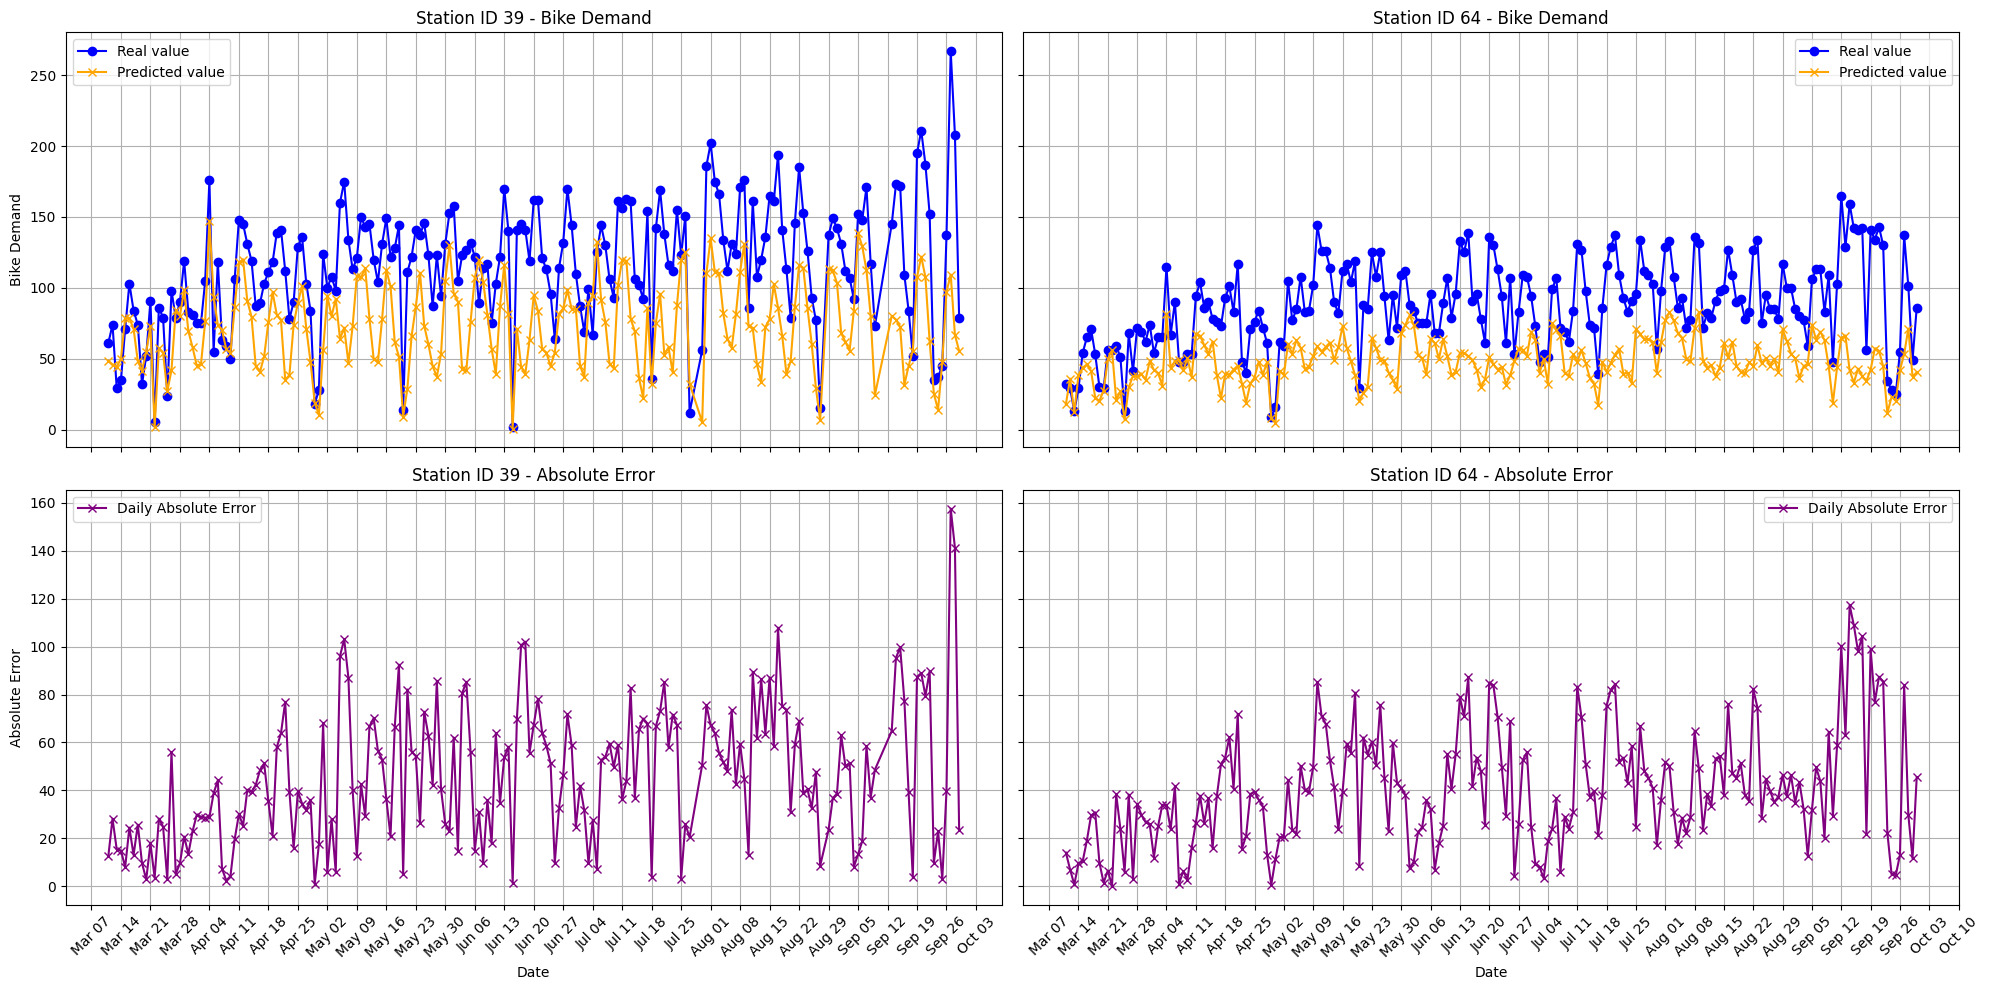

In [ ]:
# Group the data by date for daily aggregation
daily_data_station_1 = data_station_1.groupby('date').agg({'start_count':'sum', 'prediction':'sum'}).reset_index()
daily_data_station_2 = data_station_2.groupby('date').agg({'start_count':'sum', 'prediction':'sum'}).reset_index()

daily_data_station_1['date'] = pd.to_datetime(daily_data_station_1['date'])
daily_data_station_2['date'] = pd.to_datetime(daily_data_station_2['date'])
date_min = daily_data_station_1['date'].min()
date_max = daily_data_station_1['date'].max()

# Function to plot actual vs predicted values and daily MAE for two stations side by side
def plot_stations_side_by_side(daily_data_1, station_id_1, daily_data_2, station_id_2):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex='col', sharey='row')
    daily_data_1['daily_absolute_error'] = abs(daily_data_1['start_count'] - daily_data_1['prediction'])
    daily_data_2['daily_absolute_error'] = abs(daily_data_2['start_count'] - daily_data_2['prediction'])
    # Plot for Station 1 - Actual vs Predicted Demand
    axes[0, 0].plot(daily_data_1['date'],
                    daily_data_1['start_count'], label='Real value', color='blue', marker='o')
    axes[0, 0].plot(daily_data_1['date'],
                    daily_data_1['prediction'], label='Predicted value', color='orange', marker='x')
    axes[0, 0].set_title(f'Station ID {station_id_1} - Bike Demand')
    axes[0, 0].set_ylabel('Bike Demand')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot for Station 2 - Actual vs Predicted Demand
    axes[0, 1].plot(daily_data_2['date'],
                    daily_data_2['start_count'], label='Real value', color='blue', marker='o')
    axes[0, 1].plot(daily_data_2['date'],
                    daily_data_2['prediction'], label='Predicted value', color='orange', marker='x')
    axes[0, 1].set_title(f'Station ID {station_id_2} - Bike Demand')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot for Station 1 - Daily MAE
    axes[1, 0].plot(daily_data_1['date'],
                    daily_data_1['daily_absolute_error'], label='Daily Absolute Error', color='purple', marker='x')
    axes[1, 0].set_title(f'Station ID {station_id_1} - Absolute Error')
    axes[1, 0].set_ylabel('Absolute Error')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot for Station 2 - Daily MAE
    axes[1, 1].plot(daily_data_2['date'],
                    daily_data_2['daily_absolute_error'], label='Daily Absolute Error', color='purple', marker='x')
    axes[1, 1].set_title(f'Station ID {station_id_2} - Absolute Error')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Format the date on x-axis
    for ax in axes.flat:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

plot_stations_side_by_side(daily_data_station_1, 39, daily_data_station_2, 64)


# Hourly plots

<ipython-input-170-a50d136d3607>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_data['hourly_absolute_error'] = abs(hourly_data['start_count'] - hourly_data['prediction'])
<ipython-input-170-a50d136d3607>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_data['hourly_absolute_error'] = abs(hourly_data['start_count'] - hourly_data['prediction'])


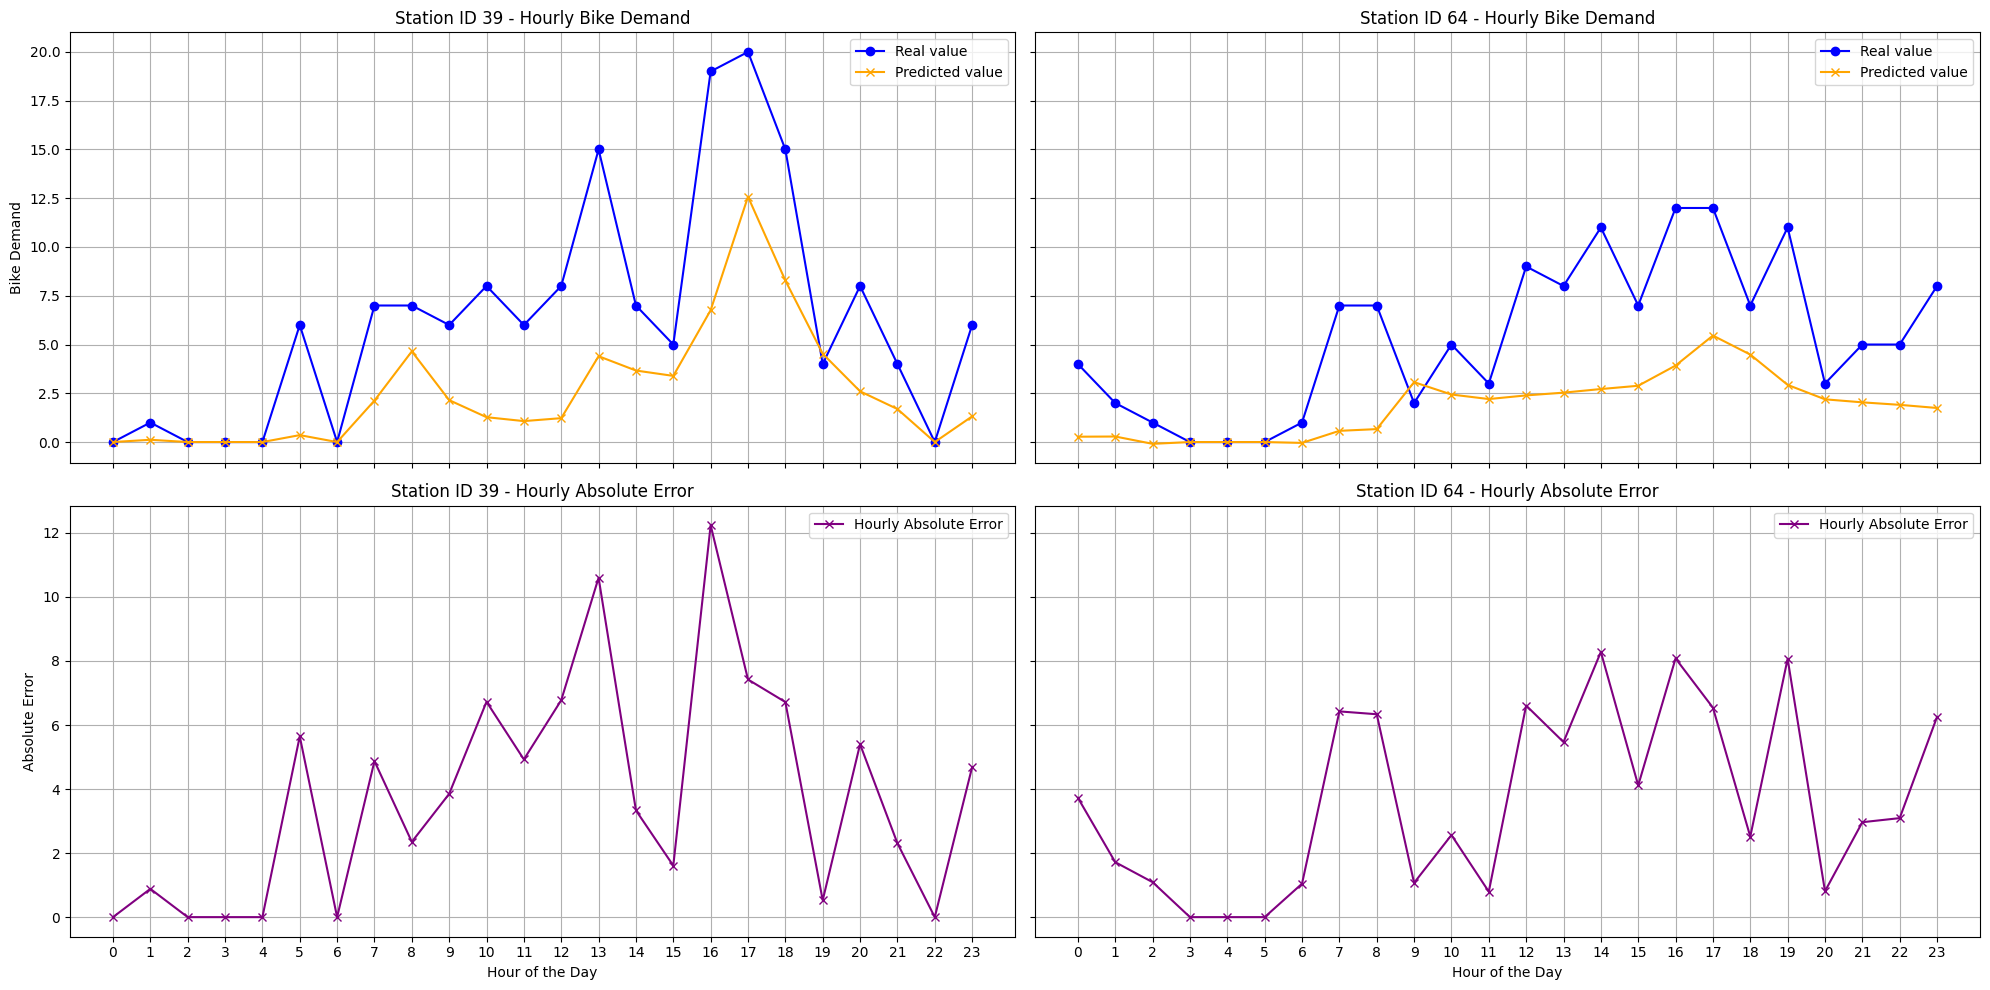

In [ ]:
X_test_reset['date'] = pd.to_datetime(X_test_reset['date'])
example_date = "2023-09-22"

# Function to prepare data for a station
def prepare_station_data(station_id, example_date):
    hourly_data = X_test_reset[(X_test_reset['station_id_encoded'] == station_id) & (X_test_reset['date'] == example_date)]
    hourly_data['hourly_absolute_error'] = abs(hourly_data['start_count'] - hourly_data['prediction'])
    hourly_range = np.arange(0, 24)
    hourly_data = hourly_data.set_index('hour').reindex(hourly_range).reset_index()
    hourly_data.fillna({'start_count': 0, 'prediction': 0, 'hourly_absolute_error': 0}, inplace=True)
    return hourly_data

# Prepare data for both stations
hourly_data_station_39 = prepare_station_data(39, example_date)
hourly_data_station_64 = prepare_station_data(64, example_date)

# Set the figure size for subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex='col', sharey='row')

# Plotting for Station 39
axes[0, 0].plot(hourly_data_station_39['hour'], hourly_data_station_39['start_count'], label='Real value', color='blue', marker='o')
axes[0, 0].plot(hourly_data_station_39['hour'], hourly_data_station_39['prediction'], label='Predicted value', color='orange', marker='x')
axes[0, 0].set_title(f'Station ID 39 - Hourly Bike Demand')
axes[0, 0].set_ylabel('Bike Demand')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[1, 0].plot(hourly_data_station_39['hour'], hourly_data_station_39['hourly_absolute_error'], label='Hourly Absolute Error', color='purple', marker='x')
axes[1, 0].set_title(f'Station ID 39 - Hourly Absolute Error')
axes[1, 0].set_ylabel('Absolute Error')
axes[1, 0].set_xlabel('Hour of the Day')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting for Station 64
axes[0, 1].plot(hourly_data_station_64['hour'], hourly_data_station_64['start_count'], label='Real value', color='blue', marker='o')
axes[0, 1].plot(hourly_data_station_64['hour'], hourly_data_station_64['prediction'], label='Predicted value', color='orange', marker='x')
axes[0, 1].set_title(f'Station ID 64 - Hourly Bike Demand')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 1].plot(hourly_data_station_64['hour'], hourly_data_station_64['hourly_absolute_error'], label='Hourly Absolute Error', color='purple', marker='x')
axes[1, 1].set_title(f'Station ID 64 - Hourly Absolute Error')
axes[1, 1].set_xlabel('Hour of the Day')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Set x-axis for all hours of the day
hourly_range = np.arange(0, 24)
for ax in axes.flat:
    ax.set_xticks(hourly_range)
    ax.set_xticklabels(hourly_range)

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Heatmap

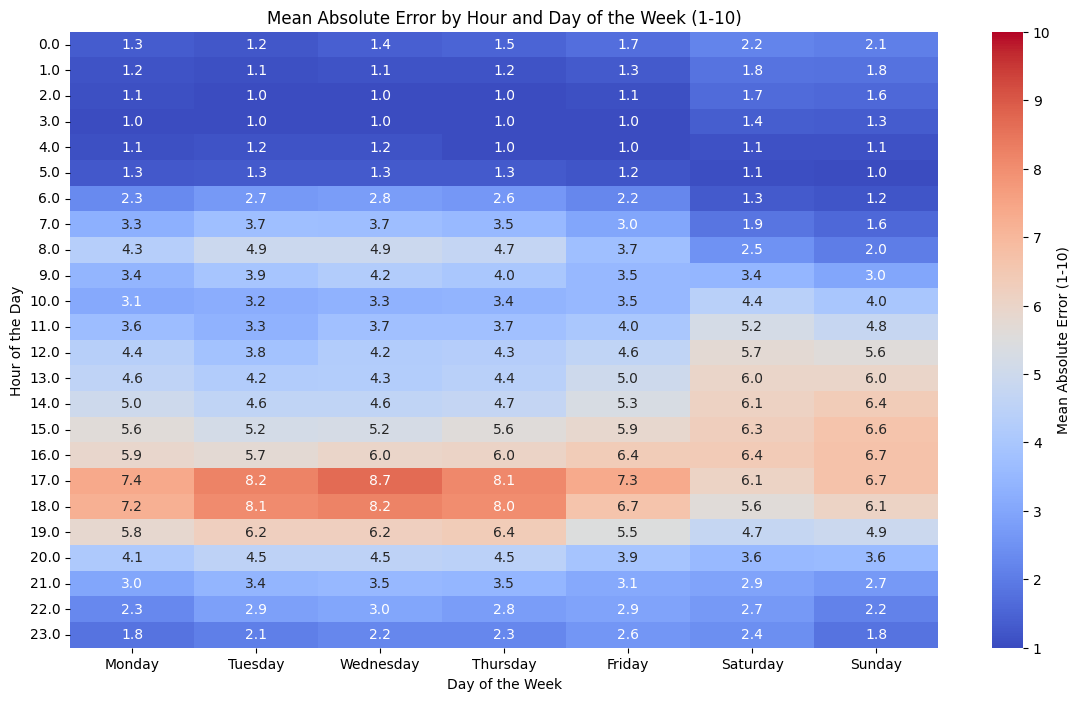

In [ ]:
# Convert 'date' column to datetime
X_test_reset['date'] = pd.to_datetime(X_test_reset['date'])
# Calculate the error between predictions and actual start count
X_test_reset['error'] = (X_test_reset['start_count'] - X_test_reset['prediction']).abs()

# Extract day of week and month from 'date'
X_test_reset['day_of_week'] = X_test_reset['date'].dt.day_name()
X_test_reset['month'] = X_test_reset['date'].dt.month_name()



# Create a pivot table with mean absolute error for each hour and day of the week
error_pivot = X_test_reset.pivot_table(values='error', index='hour', columns='day_of_week', aggfunc='mean')

# Reorder the columns to have the days in the correct order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
error_pivot = error_pivot[ordered_days]

# Plot a heatmap with the scaled error pivot table
plt.figure(figsize=(14, 8))
sns.heatmap(error_pivot, vmin=1, vmax=10, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Mean Absolute Error (1-10)'})
plt.title('Mean Absolute Error by Hour and Day of the Week (1-10)')
plt.ylabel('Hour of the Day')
plt.xlabel('Day of the Week')
plt.show()



